# Electronic Markets Assigment

# Volatility Estimation and Microstructure Biases

### Sébastien David, Arthur Bagourd, Mounah Bizri

### Master 203

***

Suppose we have a lognormal process $X_t = \ln S_t $ where $S_t$ is the stock price:

$$ dX_t = \mu_t dt + \sigma_t dB_t $$.

## 1. Naïve estimator

It is common practice to estimate volatility through a sum of sampled squared returns:

$$ [X,X]_T = \sum_{t_i} (X_{t_{i+1}}-X_{t_i})^2 $$

This estimator relies on the following approximation that the the sum of sampled squared returns converges to the continuous-time volatility:

$$ \lim_{t_i \rightarrow \infty} \sum_{t_i} (X_{t_{i+1}}-X_{t_i})^2 = \int_{0}^T \sigma_t^2 dt $$

We implement this in Python:

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def volNaive(Price):
    Returns=np.log(Price[1:]/Price[1:].shift(-1))
    return np.std(Returns)

According to Zhang, Mykland and Aït-Sahalia (2005), this approach only works for extremely high sampling frequences and is inconsistent with real-world market microstructure where return time series are sampled at multiple tick sizes. We thus need to correct for microstructure biases (not taking into account the existence of a bid-ask spread for example).

## 2. ZMA estimator

A common approach among researchers who wish to correct microstructure biases is to choose lower sampling frequencies. But this approach might lead to discaring large amounts of data. For Zhang, Mykland and Aït-Sahalia (2005), reducing sampling frequency is not sufficient to correct for microstructure biases, it merely increases its impact on volatility estimation.

One model-free solution proposed by Zhang, Mykland and Aït-Sahalia (2005) is to consider returns as an unobservable $X_t$ latent variable and $Y_t$ our best estimation of the latent returns.

$$ Y_{t_i} = X_{t_i} + \varepsilon_{t_i} $$

ZMA offer 5 possible estimators to implement:

1. *Naïve estimator*
2. *Lower frequency estimator*
3. *Optimal lower frequency estimator*
4. *Average of subsampled estimators*
5. *Average of subsampled estimators + Naïve estimator*

We will focus on their "first-best approach" (the 5th). We start by computing the naïve estimator:

$$ [Y,Y]_T^{(all)} = \sum_{i=1}^N (Y_{t_{i+1}}-Y_{t_i})^2 $$

with $N$ the number of observation of our data sample over all period $T$. Since $[Y,Y]_T^{(all)}$ is prone to market microstructure biases but at the same time it is hard to find the optimal sampling frequency for the volatility estimator. One solution proposed by ZMA is to average estimators $[Y,Y]_T^{(k)}$ across $K$ grids of average size $\bar n$, given by $[Y,Y]_T^{(avg)}$:

$$ [Y,Y]_T^{(avg)} = \frac{1}{K} \sum_{k=1}^K [Y,Y]_T^{(k)} $$

The "first-best approach" combines both the **naïve estimator** $[Y,Y]_T^{(all)}$ and the **average of subsampled estimators** $[Y,Y]_T^{(avg)}$, and gives an estimation of the latent $X_{t}$ process:

$$ \hat{[X,X]_T} = [Y,Y]_T^{(avg)} - \frac{\bar n}{n} [Y,Y]_T^{(all)} $$

where $n$ is the number of observations, $\bar n$ is the subsample size of a grid (which we get through $\bar n = \frac{n}{K} $) and $K = cn^{2/3}$ is the number of grids with $c = (\frac{T}{12(E\varepsilon^2)^2} \int_0^T \sigma_t^4 dt)^{-1/3}$.

Finally, we compute the adjusted estimator:

$$ \hat{[X,X]_T}^{(adj)} = (1 - \frac{\bar n}{n})^{-1} \hat{[X,X]_T}   $$

We start by computing:

$$ [Y,Y]_T^{(avg)} = \frac{1}{K} \sum_{k=1}^K [Y,Y]_T^{(k)} $$

We compute the naïve estimator:

$$ [Y,Y]_T^{(avg)} = \frac{1}{K} \sum_{k=1}^K [Y,Y]_T^{(k)} $$

Thus, we get:

$$ \hat{[X,X]_T} = [Y,Y]_T^{(avg)} - \frac{\bar n}{n} [Y,Y]_T^{(all)} $$

$$ \hat{[X,X]_T}^{(adj)} = (1 - \frac{\bar n}{n})^{-1} \hat{[X,X]_T}   $$

In [3]:
def ZMA_estimator(Price,K):
    """
    Zhang, Mykland & Aït-Sahalia (adjusted) volatility estimator
    """
    # Initialization
    n = Price.shape[0]
    c = 0.25   # This needs to be changed: formula is very complex
    ##K = c * n ** (2/3)
    ##K = int(K)
    n_bar = n / K
    
    # Partition
    def split_seq(seq, size):
        newseq = []
        splitsize = 1.0/size*len(seq)
        for i in range(size):
                newseq.append(seq[int(round(i*splitsize)):int(round((i+1)*splitsize))])
        return newseq
    
    ret_ks = split_seq(Price, K)
    # print(K)
    # Compute vol_k for the entire partition and vol_average
    vol_ks = []
    for ret_k in ret_ks:
        vol_k = volNaive(ret_k)
        vol_ks.append(vol_k)
    
    vol_average = np.mean(vol_ks)
    
    # Compute ZMA estimator
    vol = vol_average - n_bar/n * volNaive(Price)
    vol_adj = (1 - n_bar/n)**(-1) * vol
    
    return vol_adj

## 3. Parkinson estimator

The issue with the usual way to calculate volatility is that we only take the Close-to-close price. Thus the estimator does not really capture the information of the price moves during the day. To correct this drawback, Parkinson used the High(H) and Low(L) prices for each period of computation. It allows to better capture the moves during the period of computation.


$$ \sigma_{Park} = \sqrt{\frac{F}{N}} \sqrt{\frac{1}{4\ln(2)}\sum_{i=1}^{N} [ln(\frac{h_i}{l_i})]^2} $$

In [4]:
def parkinson(High,Low):
    return np.sqrt(1/(4*np.log(2))*np.sum(np.log(High[1:]/Low[1:])**2)*1/(len(High)-1))

## 4. Garman-Klass estimator

There are different methods of calculating volatility using some or all of the open (O), high (H), low (L) and close (C). The Garman-Klass estimator is an extension of Parkinson which includes opening and closing prices. The limit of the Parkinson estimator is that even if it takes into account the variation within a trading period, it does not take into account the Open and the Close whereas there are the moment where the trading volumes are the most intense, thus they are non-negligible (if opening prices are not available the close from the previous day can be used instead).

$$ \sigma_{GK} = \sqrt{\frac{F}{N}} \sqrt{\sum_{i=1}^{N} [\frac{1}{2}[ln(\frac{h_i}{l_i})]^2 - (2\ln(2)-1) [\ln(\frac{c_i}{o_i})]^2 ]} $$

In [5]:
def garman_klass(High,Low,Open,Close):
    """
    Garman-Klass volatility estimator. Requires dataframe with Open, High, Low and Close prices.
    """
    log_hl = np.log(High[1:] / Low[1:])
    log_cc = np.log(Close[1:] /Open[1:])
    ans = 0.5*log_hl**2 - (2*np.log(2)-1) * log_cc**2
    return np.sqrt(np.sum(ans)*1/(len(High)-1))

## 5. Rogers-Satchell Estimator

All the previous models tried to provide a consistent solution to estimate the volatility. However, they all assumed a zero-drift on average. They assumed there was no trend for the price path. Usually, for option pricing, we use a geometric brownian motion with a drift to model the stock price path. Consequently, it is a flaw that has to be fixed. Rogers Satchell tried to solve this issue by using the product of the log fraction of both high and low over the open and the close. Then, they take the difference of both. However, it underestimates volatility as it does not take jumps into account.

$$ \sigma_{RS} = \sqrt{\frac{F}{N}} \sqrt{\sum_{i=1}^{N} [ln(\frac{h_i}{c_i})ln(\frac{h_i}{o_i}) + ln(\frac{l_i}{c_i})ln(\frac{l_i}{o_i})  ]} $$

In [6]:
def rogers_satchell(High,Low,Open,Close):
    val=np.log(High[1:]/Close[1:])*np.log(High[1:]/Open[1:])+np.log(Low[1:]/Close[1:])*np.log(Low[1:]/Open[1:])
    return np.sqrt(np.sum(val)*1/len(High))

## 6. Garman-Klass : Yang-Zang Extension

One of the main drawbacks of the estimators previously introduced are that they do not take into account jumps in prices. This involves a downward bias, because volatility is underestimated. Yang Zang tried to provide an extension to the Garman-Klass estimator so that jumps are handled. The most common jumps come from the change between closing and opening. To take it into account, they simply add another commponent to the Garman-Klass model which is the squared log fraction between the closing of the previous day and the opening today. This will result in an estimation which is always greater than the Garman Klass one unless closing and opening are equals through the whole trading period

$$ \sigma_{GK} = \sqrt{\frac{F}{N}} \sqrt{\sum_{i=1}^{N} [[ln(\frac{o_i}{c_{i-1}})]^2+\frac{1}{2}[ln(\frac{h_i}{l_i})]^2 - (2\ln(2)-1) [\ln(\frac{c_i}{o_i})]^2 ]} $$

In [7]:
def garman_klass_yang_zang(High,Low,Open,Close):
    val=np.log(Open[1:]/Close[1:].shift(-1))**2+0.5*(np.log(High[1:]/Low[1:]))**2+(2*np.log(2)-1)*(np.log(Close[1:]/Open[1:]))**2
    return np.sqrt(np.sum(val)*1/(len(High)-1))

## 7. Implementation on market data

Total SA data extracted from Bloomberg for March 1st 2018 to April 13th 2018:

In [8]:
import pandas as pd

path='data.xlsx'
data1 = pd.read_excel(path, sheetname='10_min_FP', header=0, index_col=0)
data2 = pd.read_excel(path, sheetname='5_min_FP', header=0, index_col=0)
data3 = pd.read_excel(path, sheetname='1_min_FP', header=0, index_col=0)

## 1 Minute Data Test

In [37]:
max_length=data3.shape[0]
SubPeriod=470
Border_up=500
Border_down=0
Garman_KlassS=[]
ParkinsonS=[]
Rogers_SatchellS=[]
Garman_Klass_Yang_ZangS=[]
VolNaives=[]
ZMAs=[]
Number_Periods=int((max_length-SubPeriod)/100)
Time_Period=[]
for j in range(0,Number_Periods):
    High=data3["High"][j*100:SubPeriod+j*100]
    ##High=np.log(High[1:]/High[1:].shift(-1))
    Low=data3["Low"][j*100:SubPeriod+j*100]
    ##Low=np.log(Low[1:]/Low[1:].shift(-1))
    Open=data3["Open"][j*100:SubPeriod+j*100]
    ##Open=np.log(Open[1:]/Open[1:].shift(-1))
    Close=data3["Close"][j*100:SubPeriod+j*100]
    ##Close=np.log(Close[1:]/Close[1:].shift(-1))
    Mid=(High+Low)/2
    Garman_KlassS.append(garman_klass(High,Low,Open,Close)*np.sqrt(252))
    ParkinsonS.append(parkinson(High,Low)*np.sqrt(252))
    Rogers_SatchellS.append(rogers_satchell(High,Low,Open,Close)*np.sqrt(252))
    Garman_Klass_Yang_ZangS.append(garman_klass_yang_zang(High,Low,Open,Close)*np.sqrt(252))
    VolNaives.append(volNaive(Mid)*np.sqrt(252))
    ZMAs.append(ZMA_estimator(Mid,10)*np.sqrt(252))
    Time_Period.append(j*100+SubPeriod)

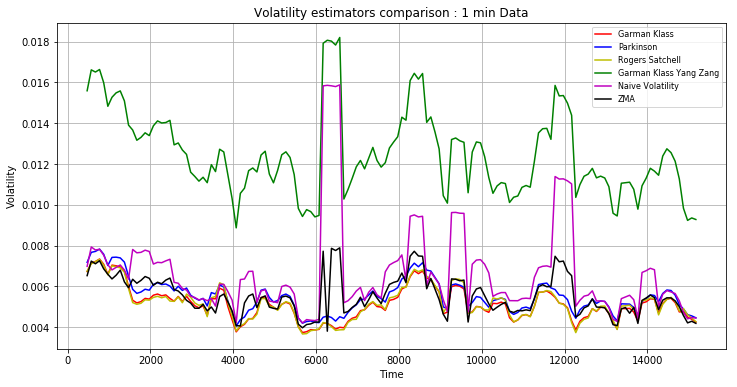

In [38]:
plt.figure(figsize=(12,6))
plt.plot(Time_Period,Garman_KlassS,color="r",label="Garman Klass")
plt.plot(Time_Period,ParkinsonS,color="b",label="Parkinson")
plt.plot(Time_Period,Rogers_SatchellS,color="y",label="Rogers Satchell")
plt.plot(Time_Period,Garman_Klass_Yang_ZangS,color="g",label="Garman Klass Yang Zang")
plt.plot(Time_Period,VolNaives,color="m",label="Naive Volatility")
plt.plot(Time_Period,ZMAs,color="k",label="ZMA")
plt.title("Volatility estimators comparison : 1 min Data")
plt.legend(loc='best', prop={'size': 8})
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.grid(True)
#plt.savefig('vol1min.png')
plt.show()

## 5 Minutes Data Test

In [39]:
max_length=data2.shape[0]
SubPeriod=90
Border_up=500
Border_down=0
Garman_KlassS=[]
ParkinsonS=[]
Rogers_SatchellS=[]
Garman_Klass_Yang_ZangS=[]
VolNaives=[]
ZMAs=[]
Number_Periods=int((max_length-SubPeriod)/20)
Time_Period=[]
for j in range(0,Number_Periods):
    High=data3["High"][j*20:SubPeriod+j*20]
    ##High=np.log(High[1:]/High[1:].shift(-1))
    Low=data3["Low"][j*20:SubPeriod+j*20]
    ##Low=np.log(Low[1:]/Low[1:].shift(-1))
    Open=data3["Open"][j*20:SubPeriod+j*20]
    ##Open=np.log(Open[1:]/Open[1:].shift(-1))
    Close=data3["Close"][j*20:SubPeriod+j*20]
    ##Close=np.log(Close[1:]/Close[1:].shift(-1))
    Mid=(High+Low)/2
    Garman_KlassS.append(garman_klass(High,Low,Open,Close)*np.sqrt(252))
    ParkinsonS.append(parkinson(High,Low)*np.sqrt(252))
    Rogers_SatchellS.append(rogers_satchell(High,Low,Open,Close)*np.sqrt(252))
    Garman_Klass_Yang_ZangS.append(garman_klass_yang_zang(High,Low,Open,Close)*np.sqrt(252))
    VolNaives.append(volNaive(Mid)*np.sqrt(252))
    ZMAs.append(ZMA_estimator(Mid,15)*np.sqrt(252))
    Time_Period.append(j*20+SubPeriod)


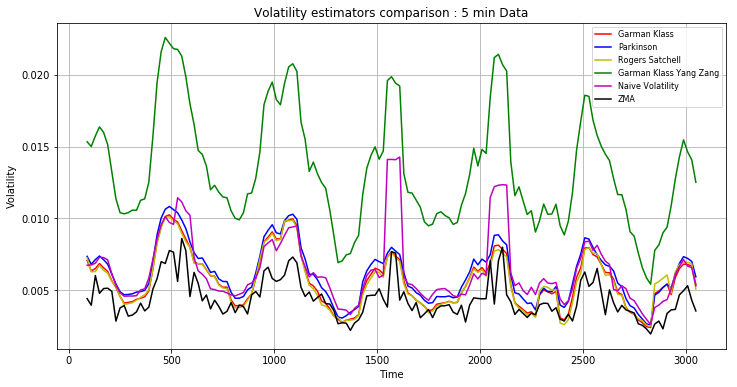

In [40]:
plt.figure(figsize=(12,6))
plt.plot(Time_Period,Garman_KlassS,color="r",label="Garman Klass")
plt.plot(Time_Period,ParkinsonS,color="b",label="Parkinson")
plt.plot(Time_Period,Rogers_SatchellS,color="y",label="Rogers Satchell")
plt.plot(Time_Period,Garman_Klass_Yang_ZangS,color="g",label="Garman Klass Yang Zang")
plt.plot(Time_Period,VolNaives,color="m",label="Naive Volatility")
plt.plot(Time_Period,ZMAs,color="k",label="ZMA")
plt.title("Volatility estimators comparison : 5 min Data")
plt.legend(loc='best', prop={'size': 8})
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.grid(True)
#plt.savefig('vol5min.png')
plt.show()

## 10 Minutes Data Test

In [43]:
max_length=data1.shape[0]
SubPeriod=50
Border_up=500
Border_down=0
Garman_KlassS=[]
ParkinsonS=[]
Rogers_SatchellS=[]
Garman_Klass_Yang_ZangS=[]
VolNaives=[]
ZMAs=[]
Number_Periods=int((max_length-SubPeriod)/10)
Time_Period=[]
for j in range(0,Number_Periods):
    High=data3["High"][j*10:SubPeriod+j*10]
    ##High=np.log(High[1:]/High[1:].shift(-1))
    Low=data3["Low"][j*10:SubPeriod+j*10]
    ##Low=np.log(Low[1:]/Low[1:].shift(-1))
    Open=data3["Open"][j*10:SubPeriod+j*10]
    ##Open=np.log(Open[1:]/Open[1:].shift(-1))
    Close=data3["Close"][j*10:SubPeriod+j*10]
    ##Close=np.log(Close[1:]/Close[1:].shift(-1))
    Mid=(High+Low)/2
    Garman_KlassS.append(garman_klass(High,Low,Open,Close)*np.sqrt(252))
    ParkinsonS.append(parkinson(High,Low)*np.sqrt(252))
    Rogers_SatchellS.append(rogers_satchell(High,Low,Open,Close)*np.sqrt(252))
    Garman_Klass_Yang_ZangS.append(garman_klass_yang_zang(High,Low,Open,Close)*np.sqrt(252))
    VolNaives.append(volNaive(Mid)*np.sqrt(252))
    ZMAs.append(ZMA_estimator(Mid,10)*np.sqrt(252))
    Time_Period.append(j*10+SubPeriod)


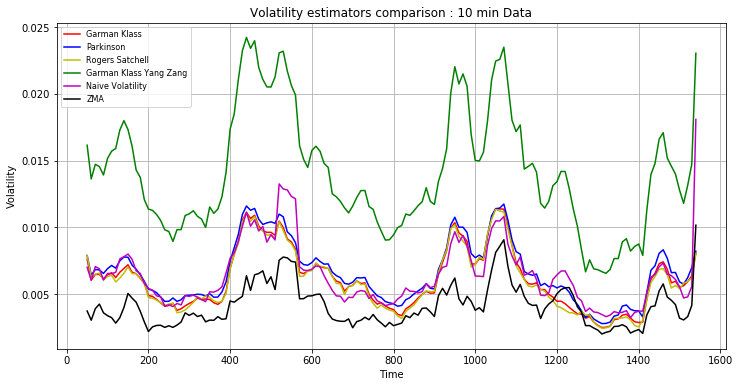

In [44]:
plt.figure(figsize=(12,6))
plt.plot(Time_Period,Garman_KlassS,color="r",label="Garman Klass")
plt.plot(Time_Period,ParkinsonS,color="b",label="Parkinson")
plt.plot(Time_Period,Rogers_SatchellS,color="y",label="Rogers Satchell")
plt.plot(Time_Period,Garman_Klass_Yang_ZangS,color="g",label="Garman Klass Yang Zang")
plt.plot(Time_Period,VolNaives,color="m",label="Naive Volatility")
plt.plot(Time_Period,ZMAs,color="k",label="ZMA")
plt.title("Volatility estimators comparison : 10 min Data")
plt.legend(loc='best', prop={'size': 8})
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Volatility')
#plt.savefig('vol10min.png')
plt.show()

## 8. Bonus: Dynamic programming and volatility estimators

Data:

In [45]:
max_length=data3.shape[0]
SubPeriod=470
Border_up=500
Border_down=0
Garman_KlassS=[]
ParkinsonS=[]
Rogers_SatchellS=[]
Garman_Klass_Yang_ZangS=[]
VolNaives=[]
ZMAs=[]
Number_Periods=int((max_length-SubPeriod)/100)
Time_Period=[]
for j in range(0,Number_Periods):
    High=data3["High"][j*100:SubPeriod+j*100]
    ##High=np.log(High[1:]/High[1:].shift(-1))
    Low=data3["Low"][j*100:SubPeriod+j*100]
    ##Low=np.log(Low[1:]/Low[1:].shift(-1))
    Open=data3["Open"][j*100:SubPeriod+j*100]
    ##Open=np.log(Open[1:]/Open[1:].shift(-1))
    Close=data3["Close"][j*100:SubPeriod+j*100]
    ##Close=np.log(Close[1:]/Close[1:].shift(-1))
    Mid=(High+Low)/2
    Garman_KlassS.append(garman_klass(High,Low,Open,Close)*np.sqrt(252))
    ParkinsonS.append(parkinson(High,Low)*np.sqrt(252))
    Rogers_SatchellS.append(rogers_satchell(High,Low,Open,Close)*np.sqrt(252))
    Garman_Klass_Yang_ZangS.append(garman_klass_yang_zang(High,Low,Open,Close)*np.sqrt(252))
    VolNaives.append(volNaive(Mid)*np.sqrt(252))
    ZMAs.append(ZMA_estimator(Mid,10)*np.sqrt(252))
    Time_Period.append(j*100+SubPeriod)

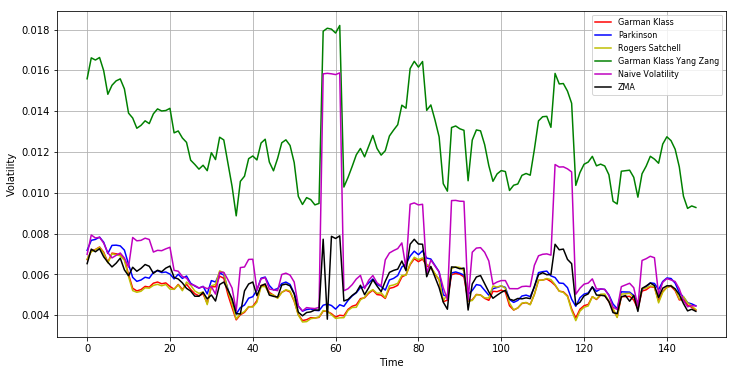

In [47]:
plt.figure(figsize=(12,6))
plt.plot(Garman_KlassS,color="r",label="Garman Klass")
plt.plot(ParkinsonS,color="b",label="Parkinson")
plt.plot(Rogers_SatchellS,color="y",label="Rogers Satchell")
plt.plot(Garman_Klass_Yang_ZangS,color="g",label="Garman Klass Yang Zang")
plt.plot(VolNaives,color="m",label="Naive Volatility")
plt.plot(ZMAs,color="k",label="ZMA")
plt.legend(loc='best', prop={'size': 8})
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Volatility')
#plt.savefig('vol10min.png')
plt.show()

In [50]:
sigma1 = VolNaives[10:60]
sigma2 = ZMAs[10:60]
sigma3 = Garman_KlassS[10:60]
sigma4 = Garman_Klass_Yang_ZangS[10:60]
sigma5 = Rogers_SatchellS[10:60]
sigma6 = ParkinsonS[10:60]

Dynamic Programming:

In [51]:
# Utilities
def h(x, alpha, eta):
    return eta * x ** (alpha)

def g(x, beta, gamma):
    return gamma * x ** (beta)

def H(x,n,psi,alpha,beta,gamma,eta,sigma=0.3,tau=0.5):
    """
    Hamiltonian equation. To be minimized through dynamic programming.
    """
    res = psi*n*g(n/tau,beta,gamma) + psi*(x-n)*tau*h(n/tau,alpha,eta) + 0.5*(psi**2)*(sigma**2)*tau*((x-n)**2)
    return res

def dynamic_programming(nb_T, X_total, psi, alpha, beta, gamma, eta, sigma, plot='True'):
    
    """
    MODEL
    - Bellman equation and value iteration for solving the Markov
      Decision Process of the Almgren-Chriss model.
    
    INPUTS
    - nb_T,       number of time steps
    - X_total,    number of shares to be liquidated
    - psi,        risk aversion
    """
    
    ### Initialization
    u = np.zeros(shape=(nb_T, X_total+1), dtype="float64")      # value function
    b = np.zeros(shape=(nb_T, X_total+1), dtype="int")          # best move
    inventoryforX = np.zeros(shape=(nb_T,1), dtype="int")       # evolution of inventory
    inventoryforX[0] = X_total
    N = []                                                      # optimal selling trajectory
    tau = 0.5
    
    ### Market microstructure: volatility, correlation
    ### [insert dynamic volatility data]
    
    ### Terminal condition
    for x in range(X_total+1):
        u[nb_T - 1, x] = np.exp(x * h(x/tau, alpha, eta))
        b[nb_T - 1, x] = x
    
    ### Backwards induction
    for t in range(nb_T-2, -1, -1):
        for x in range(X_total+1):
            
            best_value = u[t+1,0] * np.exp(H(x, x, psi, alpha, beta, gamma, eta, sigma[t]))
            best_n = x
            
            for n in range(x):
                # We compute the utility function if we sell n shares
                current_value = u[t+1,x-n] * np.exp(H(x, n, psi, alpha, beta, gamma, eta, sigma[t]))
                
                if current_value < best_value:
                    best_value = current_value
                    best_n = n   # nb of shares to liquidate
               
            u[t,x] = best_value
            b[t,x] = best_n
    
    ### Optimal trajectory
    for t in range(1, nb_T):
        inventoryforX[t] = inventoryforX[t-1] - b[t,inventoryforX[t-1]]
        N.append(b[t,inventoryforX[t-1]])
    
    N = np.asarray(N)
    
    ### Plot results
    if plot=='True':
        plt.figure(figsize=(7,5))
        plt.plot(inventoryforX, color='blue', lw=1.5)
        plt.xlabel('Trading periods')
        plt.ylabel('Number of shares')
        plt.grid(True)
        plt.show()
    
    return u, b, inventoryforX, N

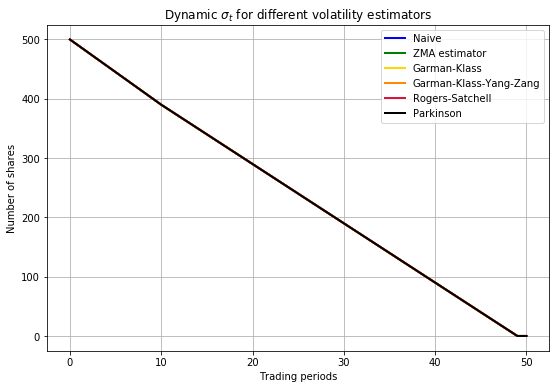

In [52]:
u1, b1, p1, N1 = dynamic_programming(nb_T=51, X_total=500, psi=0.000025, alpha=1, beta=1, gamma=0.00005, eta=0.000005, sigma=sigma1, plot='False')
u2, b2, p2, N2 = dynamic_programming(nb_T=51, X_total=500, psi=0.000025, alpha=1, beta=1, gamma=0.00005, eta=0.000005, sigma=sigma2, plot='False')
u3, b3, p3, N3 = dynamic_programming(nb_T=51, X_total=500, psi=0.000025, alpha=1, beta=1, gamma=0.00005, eta=0.000005, sigma=sigma3, plot='False')
u4, b4, p4, N4 = dynamic_programming(nb_T=51, X_total=500, psi=0.000025, alpha=1, beta=1, gamma=0.00005, eta=0.000005, sigma=sigma4, plot='False')
u5, b5, p5, N5 = dynamic_programming(nb_T=51, X_total=500, psi=0.000025, alpha=1, beta=1, gamma=0.00005, eta=0.000005, sigma=sigma5, plot='False')
u6, b6, p6, N6 = dynamic_programming(nb_T=51, X_total=500, psi=0.000025, alpha=1, beta=1, gamma=0.00005, eta=0.000005, sigma=sigma6, plot='False')

plt.figure(figsize=(9,6))

#risks = [0.000001, 0.00001, 0.000025, 0.00005]

plt.plot(p1, color='blue', lw=2, label='Naive')
plt.plot(p2, color='green', lw=2, label='ZMA estimator')
plt.plot(p3, color='gold', lw=2, label='Garman-Klass')
plt.plot(p4, color='darkorange', lw=2, label='Garman-Klass-Yang-Zang')
plt.plot(p5, color='crimson', lw=2, label='Rogers-Satchell')
plt.plot(p5, color='black', lw=2, label='Parkinson')

plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
#plt.title('$\gamma=0.000005$, $\eta=0.000005$')
plt.grid(True)
plt.title('Dynamic $\sigma_t$ for different volatility estimators')
#plt.savefig('dynamic_sigma')
plt.show()